In [1]:
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 5.1 MB/s 
     |████████████████████████████████| 168 kB 48.1 MB/s 
     |████████████████████████████████| 182 kB 41.8 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 168 kB 56.5 MB/s 
     |████████████████████████████████| 166 kB 45.2 MB/s 
     |████████████████████████████████| 166 kB 57.2 MB/s 
     |████████████████████████████████| 162 kB 54.2 MB/s 
     |████████████████████████████████| 162 kB 67.6 MB/s 
     |████████████████████████████████| 158 kB 44.5 MB/s 
     |████████████████████████████████| 157 kB 47.2 MB/s 
     |████████████████████████████████| 157 kB 48.6 MB/s 
     |████████████████████████████████| 157 kB 50.5 MB/s 
     |████████████████████████████████| 157 kB 45.7 MB/s 
     |████████████████████████████████| 157 kB 47.3 MB/s 
     |████████████████████████████████| 157 kB 14.0 MB/s 
     |████████████████████████████████| 157 kB 44.8 MB/s 
     |███████████

In [2]:
# import the necessary packages
from imutils import paths
import logging
import os
import cv2
import numpy as np
import joblib
import tensorflow as tf
import wandb
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [3]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

2.2 Fetch and Data Segregation


In [5]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "AmericanSignLanguage",
  "artifact_name": "AmericanSignLanguage_raw_data:latest",
}

In [6]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="pablosanttana",project=args["project_name"], job_type="preprocessing")

# download the raw data from W&B
raw_data = run.use_artifact(args["artifact_name"])
data_dir = raw_data.download()
logger.info("Path: {}".format(data_dir))

wandb: Currently logged in as: pablosanttana. Use `wandb login --relogin` to force relogin


wandb:   2515 of 2515 files downloaded.  
28-11-2022 00:20:56 Path: ./artifacts/AmericanSignLanguage_raw_data:v0


In [7]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

raw_wb = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     image_size=IMG_SIZE,
                                                     label_mode='categorical')

Found 2515 files belonging to 36 classes.


In [8]:
# 80% train, 20% validation and test
all_batches = tf.data.experimental.cardinality(raw_wb)
valtest_dataset = raw_wb.take(all_batches // 5)
train_dataset = raw_wb.skip(all_batches // 5)

valtest_batches = tf.data.experimental.cardinality(valtest_dataset)
test_dataset = valtest_dataset.take(valtest_batches // 5)
validation_dataset = valtest_dataset.skip(valtest_batches // 5)

In [9]:
print('Number of raw batches: %d' % tf.data.experimental.cardinality(raw_wb))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of raw batches: 79
Number of train batches: 64
Number of validation batches: 12
Number of test batches: 3


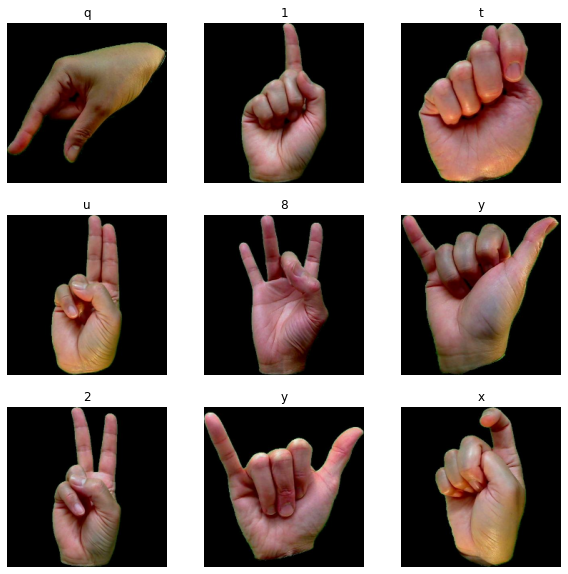

In [10]:
class_names = raw_wb.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis("off")

2.3 Configure the dataset for performance

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Use data augmentation

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

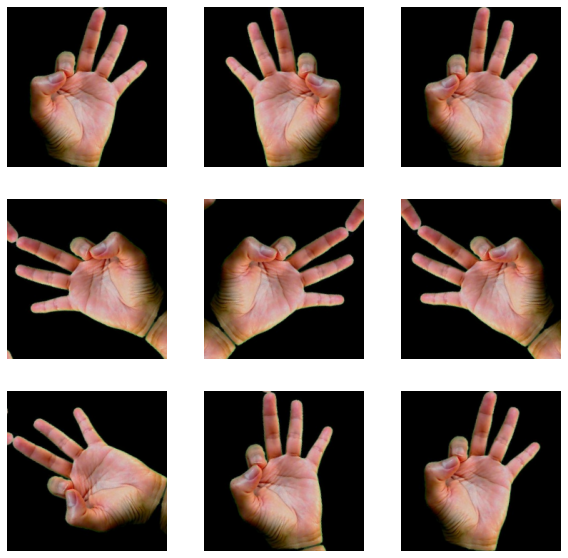

In [13]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

 Create the base model from the pre-trained convnets

In [14]:

# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [15]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


Feature extraction

In [19]:
model.trainable = False

Add a classification head

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [21]:
prediction_layer = tf.keras.layers.Dense(36,"softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 36)


In [22]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

 Compile the model



In [23]:
# initialize the optimizer and model
learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

Train and Evalute the model

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [ ]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=30,
                    verbose=1)

Epoch 1/30
 4/64 [>.............................] - ETA: 16:08 - loss: 8.9515 - accuracy: 0.0469

KeyboardInterrupt: ignored

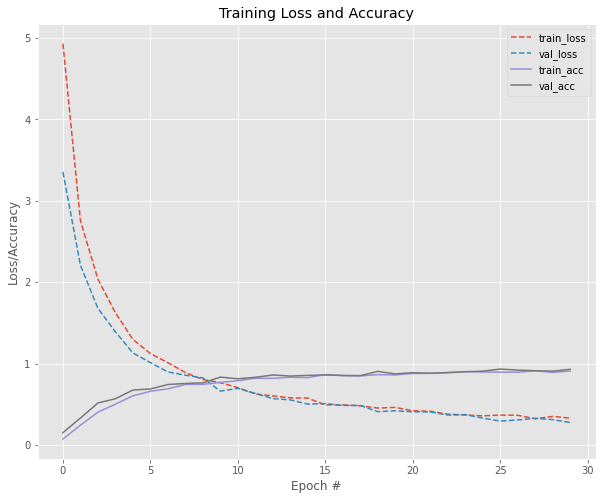

In [71]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 30), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 30), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 30), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 30), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [72]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "Training Loss and Accuracy of the transfer learning with feature extractor": wandb.Image(fig),
    }
)

28-11-2022 00:11:56 Uploading figures


In [73]:
y = np.concatenate([y for x, y in test_dataset], axis=0)
y2 = np.concatenate([y for x, y in test_dataset], axis=0)

In [74]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [75]:
# evaluate the network
print("[INFO] evaluating network...")
print(class_names)
predictions = model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names))

[INFO] evaluating network...
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
3/3 [==============================] - 1s 190ms/step


ValueError: ignored

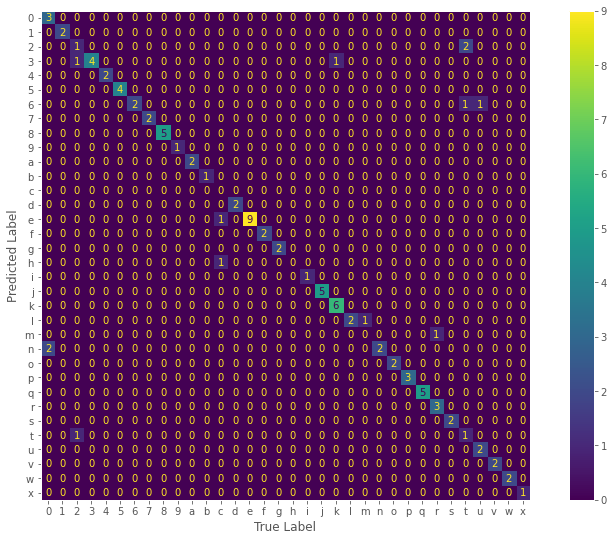

In [79]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(14,9))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix of the transfer learning with feature extractor": wandb.Image(fig_confusion_matrix),
    }
)

27-11-2022 21:31:43 Uploading figures


Transfer learning with fine-tuning

In [ ]:
# import the necessary packages
from tensorflow.keras.applications import VGG16

# whether or not to include top of CNN
include_top = 0

# load the VGG16 network
print("[INFO] loading network...")
model = VGG16(weights="imagenet", include_top= include_top > 0)
print("[INFO] showing layers...")

# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] loading network...
[INFO] showing layers...
[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	Conv2D
[INFO] 3	MaxPooling2D
[INFO] 4	Conv2D
[INFO] 5	Conv2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	Conv2D
[INFO] 9	Conv2D
[INFO] 10	MaxPooling2D
[INFO] 11	Conv2D
[INFO] 12	Conv2D
[INFO] 13	Conv2D
[INFO] 14	MaxPooling2D
[INFO] 15	Conv2D
[INFO] 16	Conv2D
[INFO] 17	Conv2D
[INFO] 18	MaxPooling2D


In [ ]:
# import the necessary packages
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# a fully connect network
class FCHeadNet:
	@staticmethod
	def build(baseModel, classes, neurons):
		# initialize the head model that will be placed on top of
		# the base, then add a FC layer
		headModel = baseModel.output
		headModel = Flatten(name="flatten")(headModel)
		headModel = Dense(neurons, activation="relu")(headModel)
		headModel = Dropout(0.5)(headModel)

		# add a softmax layer
		headModel = Dense(classes, activation="softmax")(headModel)

		# return the model
		return headModel

First Stage

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD

In [ ]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
outputs = base_model(x, training=False)
base_model = tf.keras.Model(inputs, outputs)

In [ ]:
base_model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_12  (None, 224, 224, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_12 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
Total params: 14,714,688
Trainable params: 14,714,688
Non-

In [ ]:
# initialize the new head of the network, a set of FC layers
# followed by a softmax classifier
headModel = FCHeadNet.build(base_model, len(class_names), 256)

In [ ]:
# place the head FC model on top of the base model -- this will
# become the actual model we will train
model = Model(inputs=base_model.input, outputs=headModel)

In [ ]:
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_12  (None, 224, 224, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_12 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0  

In [ ]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	SlicingOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [ ]:
# loop over all layers in the base model and freeze them so they
# will *not* be updated during the training process
for layer in model.layers[4].layers:
	layer.trainable = False

In [ ]:
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_12  (None, 224, 224, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_12 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0  

In [ ]:
# RMSprop is frequently used in situations where we need to quickly obtain
# reasonable performance (as is the case when we are trying to “warm up” a set of FC layers).
opt = RMSprop(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

In [ ]:
# train the head of the network for a few epochs (all other
# layers are frozen) -- this will allow the new FC layers to
# start to become initialized with actual "learned" values
# versus pure random
print("[INFO] training head...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=20,
                    verbose=1)

[INFO] training head...
Epoch 1/20
64/64 [==============================] - 15s 210ms/step - loss: 8.9292 - accuracy: 0.1007 - val_loss: 3.6139 - val_accuracy: 0.1224
Epoch 2/20
64/64 [==============================] - 14s 208ms/step - loss: 3.4646 - accuracy: 0.1597 - val_loss: 2.7815 - val_accuracy: 0.2552
Epoch 3/20
64/64 [==============================] - 14s 207ms/step - loss: 3.1339 - accuracy: 0.1867 - val_loss: 2.3952 - val_accuracy: 0.3281
Epoch 4/20
64/64 [==============================] - 14s 210ms/step - loss: 3.0639 - accuracy: 0.2349 - val_loss: 2.2219 - val_accuracy: 0.3594
Epoch 5/20
64/64 [==============================] - 14s 209ms/step - loss: 2.8325 - accuracy: 0.2550 - val_loss: 2.0368 - val_accuracy: 0.3906
Epoch 6/20
64/64 [==============================] - 14s 211ms/step - loss: 2.7532 - accuracy: 0.2786 - val_loss: 1.9705 - val_accuracy: 0.4323
Epoch 7/20
64/64 [==============================] - 14s 211ms/step - loss: 2.5937 - accuracy: 0.3111 - val_loss: 1.716

Second Stage

In [ ]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	SlicingOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [ ]:
# loop over the layers in the base model network and display them to the
# console
for (i, layer) in enumerate(model.layers[4].layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	Conv2D
[INFO] 3	MaxPooling2D
[INFO] 4	Conv2D
[INFO] 5	Conv2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	Conv2D
[INFO] 9	Conv2D
[INFO] 10	MaxPooling2D
[INFO] 11	Conv2D
[INFO] 12	Conv2D
[INFO] 13	Conv2D
[INFO] 14	MaxPooling2D
[INFO] 15	Conv2D
[INFO] 16	Conv2D
[INFO] 17	Conv2D
[INFO] 18	MaxPooling2D


In [ ]:
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_12  (None, 224, 224, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_12 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0  

In [ ]:
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in model.layers[4].layers[15:]:
	layer.trainable = True

In [ ]:
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_12  (None, 224, 224, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_12 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0  

In [ ]:
# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

[INFO] re-compiling model...


In [ ]:
# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
print("[INFO] training head...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=20,
                    verbose=1)

[INFO] training head...
Epoch 1/20
64/64 [==============================] - 17s 230ms/step - loss: 2.3286 - accuracy: 0.3828 - val_loss: 1.3025 - val_accuracy: 0.5755
Epoch 2/20
64/64 [==============================] - 15s 228ms/step - loss: 2.0031 - accuracy: 0.4580 - val_loss: 1.2588 - val_accuracy: 0.5677
Epoch 3/20
64/64 [==============================] - 16s 228ms/step - loss: 1.7173 - accuracy: 0.5115 - val_loss: 0.7474 - val_accuracy: 0.7891
Epoch 4/20
64/64 [==============================] - 16s 231ms/step - loss: 1.6434 - accuracy: 0.5253 - val_loss: 0.7989 - val_accuracy: 0.7370
Epoch 5/20
64/64 [==============================] - 16s 239ms/step - loss: 1.4979 - accuracy: 0.5563 - val_loss: 0.7236 - val_accuracy: 0.7474
Epoch 6/20
64/64 [==============================] - 16s 234ms/step - loss: 1.4410 - accuracy: 0.5572 - val_loss: 0.6549 - val_accuracy: 0.8047
Epoch 7/20
64/64 [==============================] - 16s 233ms/step - loss: 1.4811 - accuracy: 0.5474 - val_loss: 0.486

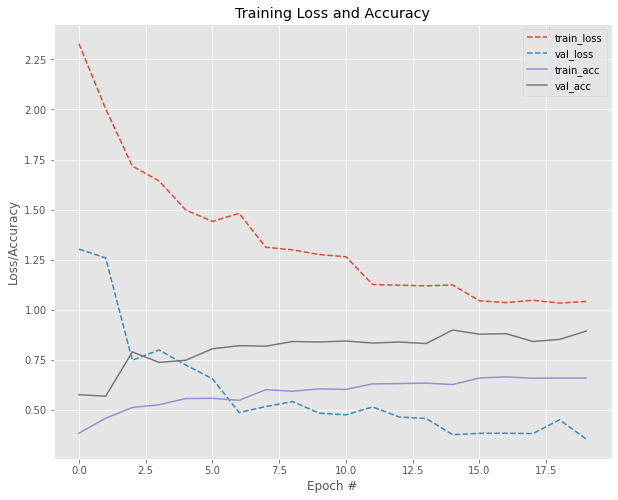

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

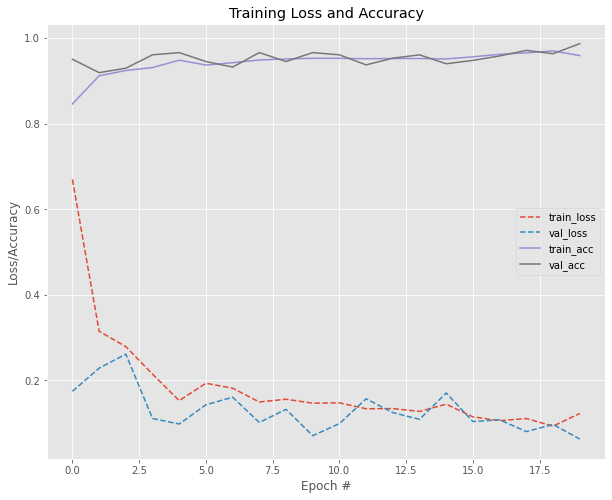

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [ ]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names))

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()